In [17]:
import numpy as np
import hydra
import torch
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from omegaconf import OmegaConf

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from utils import *
from multimodal_contrastive.utils import utils

# register custom resolvers if not already registered
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list), replace=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# Load config for CLIP model
config_name = "puma_sm_gmc"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

cfg.datamodule.split_type

'shuffled_scaffold'

In [3]:
# set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

In [4]:
# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Train on samples from shuffled_scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


In [19]:
# Get the raw morphology features
test_loader = datamodule.infer_dataloader()
loader = make_eval_data_loader(datamodule.dataset)
mods = unroll_dataloader(loader, mods=['morph'])
morph = mods['morph']

/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 133/133 [00:58<00:00,  2.25it/s]


In [6]:
# Load model from checkpoint
# ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/morph_struct.ckpt"
ckpt_path = "/home/mila/s/stephen.lu/scratch/mmc/omics-guided-gfn/05tjweok/checkpoints/epoch=22-step=2438.ckpt"
model = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(


In [7]:
# Get latent representations for full dataset
representations, mols = model.compute_representation_dataloader(
    loader,
    device=device,
    return_mol=True
)

100%|██████████| 133/133 [01:11<00:00,  1.86it/s]


In [20]:
# Get latent representations for test dataset
representations_test, mols_test = model.compute_representation_dataloader(
    test_loader,
    device=device,
    return_mol=True
)

100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


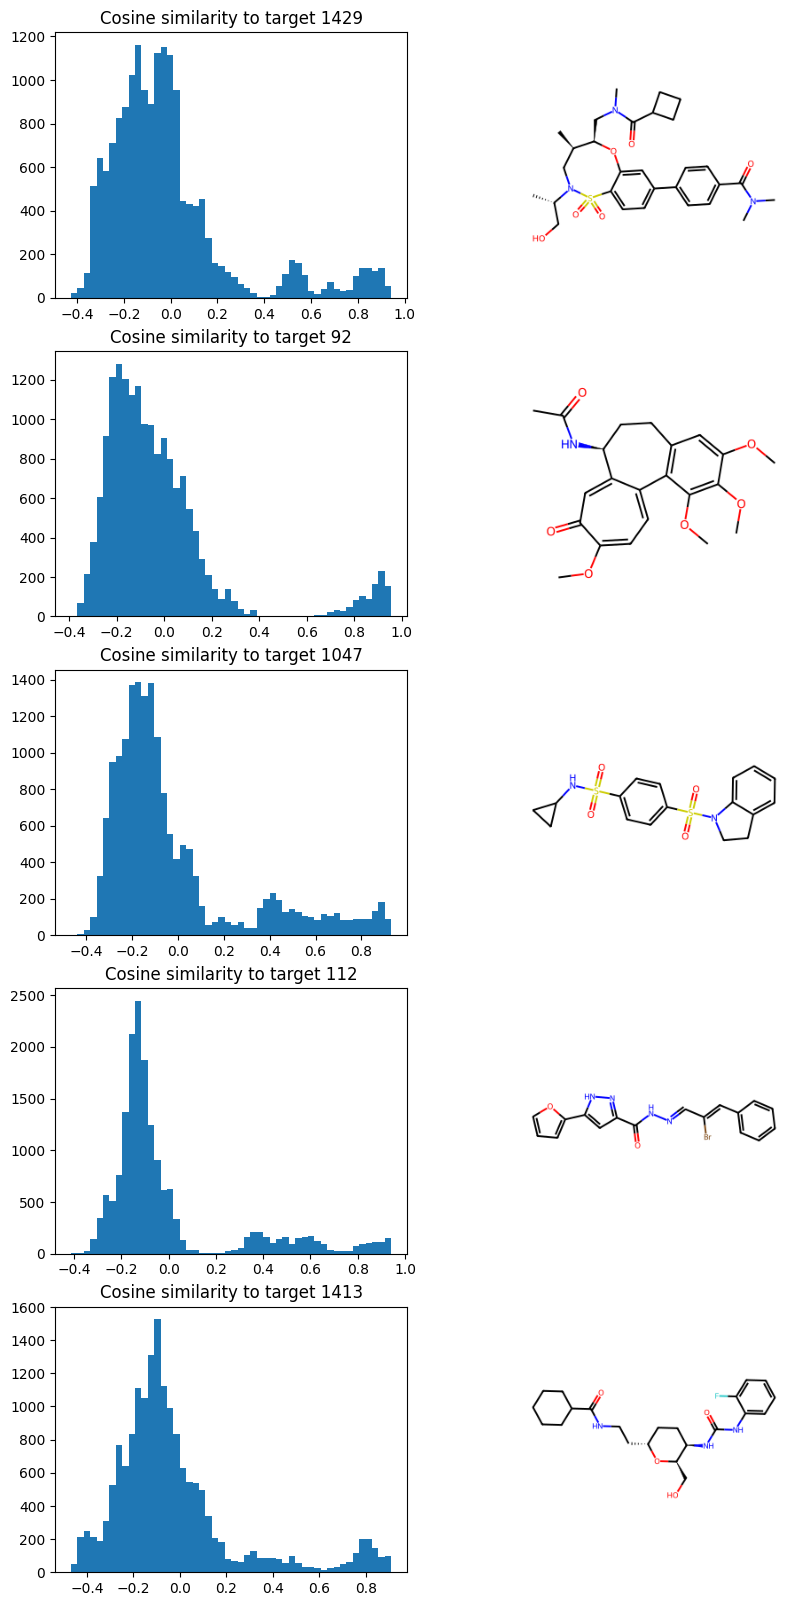

In [23]:
struct_latents = representations['struct']

n_targets = 5
fig, ax = plt.subplots(n_targets, 2, figsize=(10, 20))

for i in range(n_targets):
    # get a random target molecule and its latent representation
    target_idx = np.random.randint(len(mols_test))
    target_joint_latent = representations_test['joint'][target_idx]
    target_morph_latent = representations_test['morph'][target_idx]
    
    # compute cosine similarity between target and all struct latents
    cosine_sim = cosine_similarity([target_joint_latent], struct_latents)
    
    # plot histogram of cosine sim
    ax[i, 0].hist(cosine_sim.flatten(), bins=50)
    ax[i, 0].set_title(f"Cosine similarity to target {target_idx}")

    # plot the target molecule
    mol = mols[target_idx]
    mol = Chem.MolFromSmiles(mol)
    img = Draw.MolToImage(mol)
    ax[i, 1].imshow(img)
    ax[i, 1].axis("off")

    # save the target instance
    sample = test_loader.dataset[target_idx]
    struct = sample["inputs"]["struct"]
    smiles = struct.mols

    with open(f"sample_{target_idx}.pkl", "wb") as f:
        pickle.dump(sample, f)
    
    with open(f"sample_{target_idx}.txt", "wb") as f:
        f.write(smiles)

plt.show()